# Chapter 5: Relative Permeability (Corey's Correlation)
**Author:** Ade Anggi Naluriawan Santoso

**Objective:**
In this notebook, we will generate Relative Permeability curves ($k_{rw}$ and $k_{ro}$) for an oil-water system using the **Corey Model**.

**What is Relative Permeability?**
It describes how the presence of one fluid inhibits the flow of another.
* **$k_{rw}$:** Relative permeability to water.
* **$k_{ro}$:** Relative permeability to oil.
* **Saturation ($S_w$):** The fraction of pore space filled with water.

**The Endpoints:**
To generate these curves, we need to know the physical limits of the reservoir rock:
1.  **$S_{wc}$ (Connate Water Saturation):** The irreducible water saturation. Water cannot flow below this saturation.
2.  **$S_{or}$ (Residual Oil Saturation):** The oil remaining after a waterflood. Oil cannot flow below this saturation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Plotting Style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

## 1. Corey's Correlation Equations

Corey (1954) proposed a power-law relationship that is widely used in the industry because of its simplicity and flexibility.

### Step 1: Normalize Water Saturation ($S_w^*$)
We first convert the physical water saturation ($S_w$) into a normalized value between 0 and 1, effectively removing the "dead zones" ($S_{wc}$ and $S_{or}$).

$$S_w^* = \frac{S_w - S_{wc}}{1 - S_{wc} - S_{or}}$$

### Step 2: Calculate Relative Permeability
Using the normalized saturation, we apply the Corey exponents ($n_w$ and $n_o$):

$$k_{rw} = k_{rw}^0 \cdot (S_w^*)^{n_w}$$

$$k_{ro} = k_{ro}^0 \cdot (1 - S_w^*)^{n_o}$$

Where:
* $k_{rw}^0$: End-point relative permeability to water (usually at $S_{or}$).
* $k_{ro}^0$: End-point relative permeability to oil (usually at $S_{wc}$, often 1.0).
* $n_w, n_o$: Corey exponents (shape factors).
    * **2 to 3:** Typical for consolidated sandstones.
    * **3 to 5:** Typical for unconsolidated sands or carbonates.

In [2]:
def corey_rel_perm(Sw, Swc, Sor, nw, no, krw_end, kro_end):
    """
    Generates Oil-Water Relative Permeability curves using Corey's correlation.
    
    Args:
        Sw (array): Array of water saturation values (0 to 1).
        Swc (float): Critical/Connate water saturation.
        Sor (float): Residual oil saturation.
        nw (float): Corey exponent for water (curvature).
        no (float): Corey exponent for oil (curvature).
        krw_end (float): Max rel-perm for water at (1-Sor).
        kro_end (float): Max rel-perm for oil at Swc.
        
    Returns:
        DataFrame: Containing Sw, Sw_norm, krw, kro
    """
    # 1. Normalize Saturation
    # We clip values to ensure we don't divide by zero or go outside [0,1] bounds
    Sw_norm = (Sw - Swc) / (1 - Swc - Sor)
    
    # Clip to keep physically meaningful (0 <= Sw* <= 1)
    Sw_norm = np.clip(Sw_norm, 0, 1)
    
    # 2. Calculate Relative Permeabilities
    krw = krw_end * (Sw_norm ** nw)
    kro = kro_end * ((1 - Sw_norm) ** no)
    
    # Clean up: Where Sw < Swc, krw should be 0. Where Sw > (1-Sor), kro should be 0.
    # The clipping handled the math, but let's be explicit for physical logic
    krw = np.where(Sw < Swc, 0, krw)
    kro = np.where(Sw > (1 - Sor), 0, kro)
    
    return pd.DataFrame({'Sw': Sw, 'Sw_norm': Sw_norm, 'krw': krw, 'kro': kro})

## 2. Exercise: Generating a Water-Wet Sandstone Curve

Let's generate the curves for a typical **Water-Wet Sandstone**.

**Input Parameters:**
* $S_{wc} = 0.2$ (20% of pore space is immovable water)
* $S_{or} = 0.25$ (25% of oil is trapped)
* $k_{ro}^0 = 0.9$ (Oil endpoint)
* $k_{rw}^0 = 0.6$ (Water endpoint)
* $n_o = 3$ (Oil exponent)
* $n_w = 3$ (Water exponent)

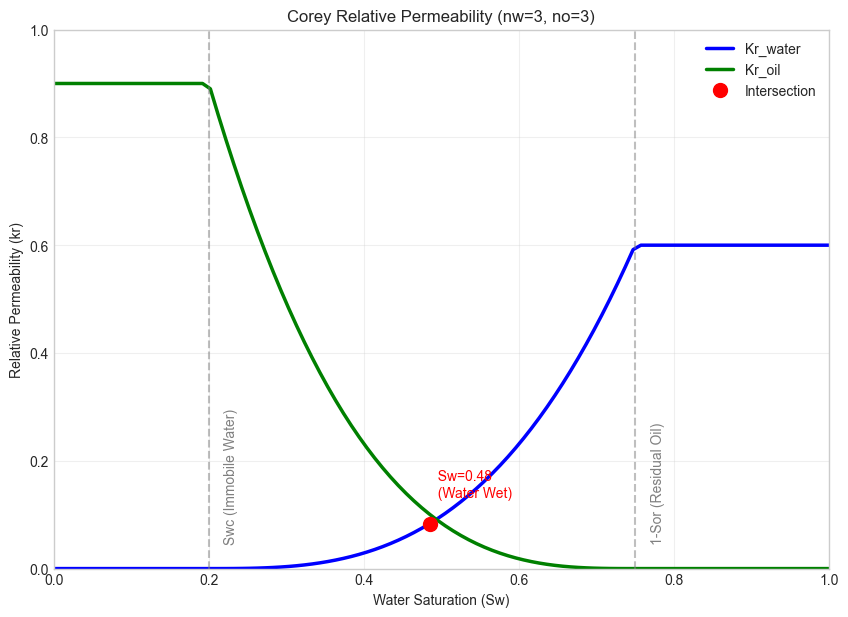

In [3]:
# --- PARAMETERS ---
Sw_range = np.linspace(0, 1, 100)
Swc_input = 0.20
Sor_input = 0.25
nw_input = 3
no_input = 3
krw_max = 0.6
kro_max = 0.9

# --- CALCULATION ---
df_relperm = corey_rel_perm(Sw_range, Swc_input, Sor_input, nw_input, no_input, krw_max, kro_max)

# --- VISUALIZATION ---
fig, ax = plt.subplots(figsize=(10, 7))

# Plot Curves
ax.plot(df_relperm['Sw'], df_relperm['krw'], 'b-', linewidth=2.5, label='Kr_water')
ax.plot(df_relperm['Sw'], df_relperm['kro'], 'g-', linewidth=2.5, label='Kr_oil')

# Plot physical limits
ax.axvline(Swc_input, color='gray', linestyle='--', alpha=0.5)
ax.axvline(1 - Sor_input, color='gray', linestyle='--', alpha=0.5)

# Annotations
ax.text(Swc_input + 0.02, 0.05, 'Swc (Immobile Water)', rotation=90, color='gray')
ax.text((1 - Sor_input) + 0.02, 0.05, '1-Sor (Residual Oil)', rotation=90, color='gray')

# Intersection Point (Where kro = krw)
# Find index where curves cross
idx = np.argwhere(np.diff(np.sign(df_relperm['krw'] - df_relperm['kro']))).flatten()
if len(idx) > 0:
    cross_sw = df_relperm['Sw'].iloc[idx[0]]
    cross_k = df_relperm['krw'].iloc[idx[0]]
    ax.plot(cross_sw, cross_k, 'ro', markersize=10, label='Intersection')
    ax.text(cross_sw, cross_k + 0.05, f'  Sw={cross_sw:.2f}\n  (Water Wet)', color='red')

# Formatting
ax.set_xlabel('Water Saturation (Sw)')
ax.set_ylabel('Relative Permeability (kr)')
ax.set_title(f'Corey Relative Permeability (nw={nw_input}, no={no_input})')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.legend()
ax.grid(True, which='both', alpha=0.3)

plt.show()

## 3. Wettability Analysis

The shape of the Relative Permeability curve tells us about the **Wettability** of the rock (i.e., does the rock prefer to be in contact with water or oil?).

A quick "Rule of Thumb" using the intersection point of the $k_{rw}$ and $k_{ro}$ curves:
* **Water Wet:** Intersection is at $S_w > 0.5$ (The water curve stays low for a long time).
* **Oil Wet:** Intersection is at $S_w < 0.5$ (The water curve shoots up quickly).
* **Mixed Wet:** Intersection is around $0.5$.

### Interactive Exercise
Let's modify the exponents to simulate an **Oil-Wet** Carbonate and compare it to our Water-Wet Sandstone.
* **Oil Wet:** Water flows easily, so $k_{rw}$ rises fast ($n_w$ is lower). Oil sticks to rock, so $k_{ro}$ drops fast ($n_o$ is higher).

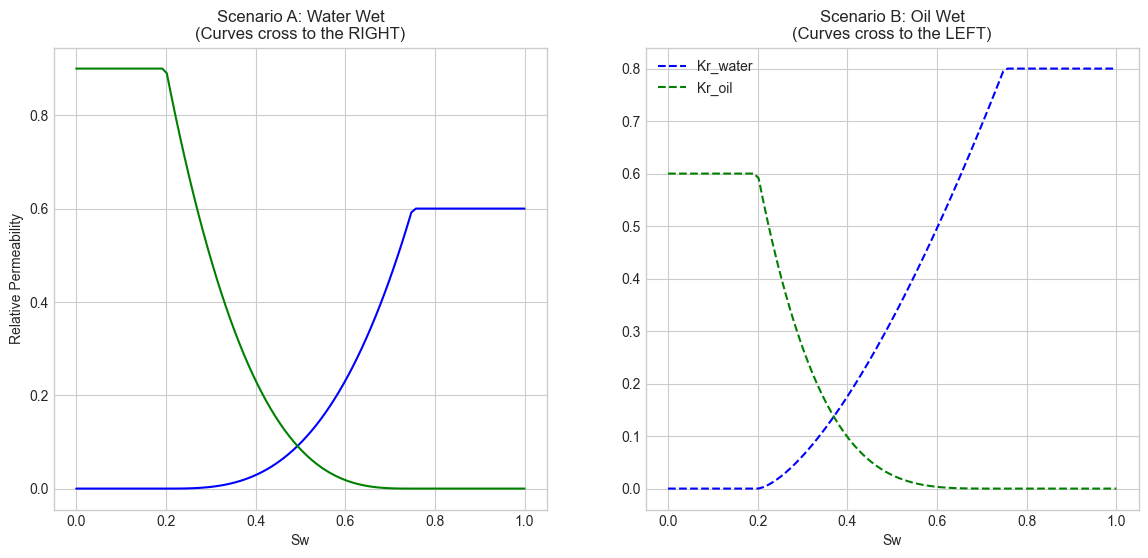

In [4]:
# Scenario A: Water Wet (Sandstone)
# High exponents (suppressed flow)
df_ww = corey_rel_perm(Sw_range, Swc=0.2, Sor=0.25, nw=3, no=3, krw_end=0.6, kro_end=0.9)

# Scenario B: Oil Wet (Carbonate)
# Lower nw (water moves easier), Higher no (oil drags)
df_ow = corey_rel_perm(Sw_range, Swc=0.2, Sor=0.25, nw=1.5, no=4, krw_end=0.8, kro_end=0.6)

# Plot comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Water Wet
ax1.plot(df_ww['Sw'], df_ww['krw'], 'b-', label='Kr_water')
ax1.plot(df_ww['Sw'], df_ww['kro'], 'g-', label='Kr_oil')
ax1.set_title('Scenario A: Water Wet\n(Curves cross to the RIGHT)')
ax1.set_xlabel('Sw')
ax1.set_ylabel('Relative Permeability')
ax1.grid(True)

# Plot 2: Oil Wet
ax2.plot(df_ow['Sw'], df_ow['krw'], 'b--', label='Kr_water')
ax2.plot(df_ow['Sw'], df_ow['kro'], 'g--', label='Kr_oil')
ax2.set_title('Scenario B: Oil Wet\n(Curves cross to the LEFT)')
ax2.set_xlabel('Sw')
ax2.grid(True)

plt.legend()
plt.show()

## Conclusion

We have successfully implemented **Corey's Model** in Python.

**Key Takeaways:**
1.  **Normalization is Key:** You must convert $S_w$ to $S_w^*$ to account for $S_{wc}$ and $S_{or}$.
2.  **Exponents Control Shape:**
    * $n$ controls the curvature.
    * Higher $n$ = More curvature = Flow is more restricted (S-shape).
3.  **Use in Simulation:** The `df_relperm` dataframe generated here can be exported to CSV and pasted directly into simulator decks (e.g., Eclipse `SWOF` keyword).